In [1]:
from itertools import product, islice

In [2]:
from testproblems import generate_random_prob
from datastructures.graphutils import edges_E, all_components

In [3]:
from datastructures.operators import invert_edges, sort_scc
from datastructures.rendering import render_incidence
from experimentutils import generate_problem
import pandas as pd
import numpy as np

In [4]:
import networkx as nx
from datastructures.tearing import dir_graph, feedbacks, min_max_scc2, min_arc_set_assign, min_arc_set

In [5]:
from ipywidgets import IntProgress
from IPython.display import display

In [6]:
independent_of_n = True

In [7]:
timeout=100

In [8]:
def custom_calculation_args(m,n,seed,sparsity):
    seed = int(seed) # required for the way we generate random problems
    eq_incidence, var_incidence, outset = generate_random_prob(m, n, seed, sparsity, independent_of_n=independent_of_n)
    edges_varonleft = edges_E(eq_incidence)
    eqnidxs = eq_incidence.keys()
    varidxs = var_incidence.keys()
    D = nx.DiGraph(dir_graph(edges_varonleft, eqnidxs, outset.items()))
    kwargs = {
        'eq_incidence':eq_incidence,
        'var_incidence':var_incidence,
        'edges_varonleft':edges_varonleft,
        'outset': outset,
        'eqnidxs':eqnidxs,
        'varidxs':varidxs,
        'D':D
    }
    return kwargs

In [9]:
import collections
from collections.abc import Iterable

#https://stackoverflow.com/questions/6710834/iterating-over-list-or-single-element-in-python
def get_iterable(x):
    if isinstance(x, Iterable) and not isinstance(x, str):
        return x
    else:
        return (x,)

In [27]:
def run_calculations(df, fxs, iter_cycles=None, filename=None):
    iter_over = iter_cycles if iter_cycles else len(df)
    f = IntProgress(min=0, max=iter_over) # instantiate the bar
    display(f)
    pd.options.mode.chained_assignment = None
    fxs = {get_iterable(names):fx for names,fx in fxs.items()}
    for names in fxs.keys():
        for name in names:
            if name not in df:
                df[name] = None
    for idx in islice(df.index,iter_over):
        row = df.iloc[idx]
        m,n,seed,sparsity = [df.at[idx,colname] for colname in ['m','n','seed','sparsity']]
        for names,fx in fxs.items():
            if any(pd.isna(row[name]) for name in names):
                kwargs = custom_calculation_args(m,n,seed,sparsity)
                out = fx(**kwargs)
                for name, val in zip(names, get_iterable(out)):
                    df[name][idx] = val
                if filename:
                    df.to_csv(filename)
        f.value += 1

In [11]:
def max_scc_calculations(D=None, **kwargs):
    max_scc = max(len(elt) for elt in nx.strongly_connected_components(D))//2
    return max_scc

In [12]:
def min_FAS_calculations(edges_varonleft=None, varidxs=None, eqnidxs=None, outset=None, **kwargs):
    try:
        cycles, elimset, m = min_arc_set(edges_varonleft, outset, varidxs, eqnidxs, timeout=timeout)
        return (m.Runtime, len(elimset))
    except:
        return (100,999)

In [13]:
def min_max_scc_calculations(edges_varonleft=None, varidxs=None, eqnidxs=None, **kwargs):
    xsol, m = min_max_scc2(edges_varonleft, varidxs, eqnidxs, timeout=timeout)
    if xsol:
        selected = tuple((right, left) for left, right in edges_varonleft if xsol[left, right] > 0.5)
        D = nx.DiGraph(dir_graph(edges_varonleft, eqnidxs, selected))
        minssc = max(len(elt) for elt in nx.strongly_connected_components(D))//2
        minssc = max(minssc,0)
    else:
        minssc = 999
    return (m.Runtime, minssc)

In [14]:
def min_tear_calculations(edges_varonleft=None, varidxs=None, eqnidxs=None, outset=None, **kwargs):
    ins = {vr for vr in varidxs if vr not in outset.values()}
    xsol, m = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs, not_output=ins, timeout=timeout)
    if xsol:
        n_eqs = len(eqnidxs)
        selected = dict((right, left-n_eqs) for left, right in edges_varonleft if xsol[left, right] > 0.5)
        guessvars = n_eqs-len(selected)
    else:
        guessvars = 999
    return m.Runtime, guessvars

In [15]:
def min_assign_calculations(edges_varonleft=None, varidxs=None, eqnidxs=None, **kwargs):
    xsol, m = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs, timeout=timeout)
    if xsol:
        n_eqs = len(eqnidxs)
        selected = dict((right, left-n_eqs) for left, right in edges_varonleft if xsol[left, right] > 0.5)
        guessvars = n_eqs-len(selected)
    else:
        guessvars = 999
    return m.Runtime, guessvars

In [16]:
def feedbacks_calculations(D=None, eqnidxs=None, **kwargs):
    guess, feedback_components = feedbacks(D, eqnidxs)
    return len(guess)    

In [33]:
#(10,),(0.1,0.2,0.5),(0.5,1.,1.5),range(10)
#df = None
df = generate_problem((10,20,30,40,50),(0.5,),(1,2,3),range(10), df=df) #0.2,0.5,

In [17]:
filename = 'full_experiments_density_indep_n.csv'

In [18]:
df = pd.read_csv(filename, index_col=0)

In [35]:
#dfcorrected = df[~((df["sparsity"]==4) & (df["maxscc"].isna()))]

In [37]:
list_of_calculations = {
    'maxscc': max_scc_calculations, 
    'guess': feedbacks_calculations,
    'density': lambda eq_incidence=None, **kwargs: np.mean([len(val) for val in eq_incidence.values()]),
    ('timeMINFAS','MINFAS'): min_FAS_calculations,
    ('timetearpart','mintearpart'): min_tear_calculations,
    ('timetearfull','mintearfull'): min_assign_calculations,
    ('timescc','minscc'): min_max_scc_calculations,
}
run_calculations(df, list_of_calculations, filename=filename)

IntProgress(value=0, max=555)

In [33]:
dfcorrected.to_csv(filename)

In [27]:
plot.plo

,m,ncoeff,n,sparsity,seed,maxscc,guess,timeMINFAS,MINFAS,timetearpart,mintearpart,timetearfull,mintearfull,timescc,minscc,density
0,10,0.1,11,3,0,10,6,0.004206,3,0.029558,1,0.021088,1,0.012703,4,3.2
1,10,0.1,11,3,1,10,4,0.009693,2,0.329609,2,0.672915,2,0.039564,9,4.1
2,10,0.1,11,3,2,10,5,0.004,2,0.072231,1,0.07325,0,0.003826,0,3.7
3,10,0.1,11,3,3,10,8,0.014692,4,0.247854,2,0.331308,2,0.041113,9,3.7
4,10,0.1,11,3,4,8,7,0.004999,3,0.247375,2,0.303759,2,0.032488,6,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,30,0.5,45,5,5,None,None,None,None,None,None,None,None,None,None,None
266,30,0.5,45,5,6,None,None,None,None,None,None,None,None,None,None,None
267,30,0.5,45,5,7,None,None,None,None,None,None,None,None,None,None,None
268,30,0.5,45,5,8,None,None,None,None,None,None,None,None,None,None,None


In [17]:
df.iloc[27]

m                  10
ncoeff            0.5
n                  15
sparsity          1.5
seed                7
maxscc             10
guess               8
timescc      6.470394
minscc              4
timeguess    2.841425
minguess            2
Name: 27, dtype: object

In [18]:
edges_varonleft,varidxs,eqnidxs = (custom_calculation_args(10,15,7,1.5)[arg] for arg in ['edges_varonleft', 'varidxs', 'eqnidxs'])

In [19]:
xsol, m = min_max_scc2(edges_varonleft, varidxs, eqnidxs, timeout=20)

In [20]:
selected = tuple((right, left) for left, right in edges_varonleft if xsol[left, right] > 0.5)

In [21]:
D = nx.DiGraph(dir_graph(edges_varonleft, eqnidxs, selected))
minassign_order = sort_scc(D, lambda x: x in eqnidxs)

In [22]:
minassign_order

[{3}, {2}, {0, 6, 7, 8}, {1, 5}, {9}, {4}]

In [248]:
kwargs = custom_calculation_args(10,15,0,1.)

In [253]:
edges_varonleft,varidxs,eqnidxs = kwargs['edges_varonleft'], kwargs['varidxs'], kwargs['eqnidxs']

In [256]:
xout, m = min_max_scc_calculations(edges_varonleft, varidxs, eqnidxs);

In [259]:
m.objVal

10.0

In [25]:
feedbacks(D, eqnidxs)

{12, 13, 14, 15, 16, 19, 20, 23}

In [7]:
edges_default = invert_edges(eq_incidence, newout=outset)
tree_default = ({elt:1 for elt in eqnidxs},{},{})

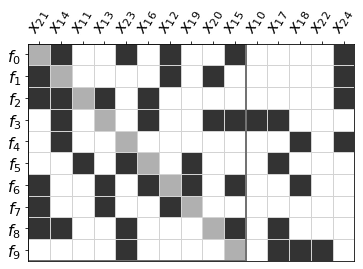

In [9]:
_, ax = render_incidence(edges_default, tree_default)